Relative to `library-design-draft.ipynb`, this notebook adds:
* Replacement of min-based and mean-based similarity scores with a KDE-based score. This has the added benefit of not requiring us to tune a temperature parameter.
* hydrophobicity

This notebook removes:
* The sections on trying to optimize an entire library at once, rather than sampling peptides individually. (The whole-library-at-a-time approach I was considering is clearly infeasible for the size of library we desire, which is in the millions of peptides.)
* Use of "aromaticity" and "molecular weight" features, and also "flexibility" feature.

To-do in the next iteration:
* Sliding-window secondary-structure propensity features
* Sequence complexity features

Requirements:
* `matplotlib`
* `numpy`
* `scipy` (fast pairwise distances)
* `sklearn`
* `pandas`
* `Biopython`
* `tqdm` (progress bars)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# 1. Load reference CPPs

In [2]:
standard_amino_acids = list('AGILPVFWYDERHKSTCMNQ')

# loading reference set from spreadsheet provided by NM (from CPPsite2.0)
# then removing sequences containing any nonstandard-looking characters
import pandas as pd
path_to_spreadsheet = 'CPPsitelist.xlsx'
initial_set = list(pd.read_excel(path_to_spreadsheet, sheetname=0, header=None)[0])
print('len(initial_set):', len(initial_set))
# remove redundancies
nonredundant_set = sorted(list(set(initial_set)))
print('len(nonredundant_set):', len(nonredundant_set))
# remove any sequences containing nonstandard characters (e.g. wildcards)
print('some peptides contained the following nonstandard characters:',
      sorted(list(set(list(''.join(nonredundant_set))).difference(standard_amino_acids))))
is_valid = lambda seq : (sum([aa in standard_amino_acids for aa in set(seq)]) / len(set(seq))) == 1
for seq in nonredundant_set:
    if not is_valid(seq):
        print('\t{}'.format(seq))
reference_set = [seq for seq in nonredundant_set if is_valid(seq)]
print('len(reference_set): ', len(reference_set))

len(initial_set): 2000
len(nonredundant_set): 2000
some peptides contained the following nonstandard characters: []
len(reference_set):  2000


C:\Users\mcneern\AppData\Local\Continuum\miniconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


**To-do:** make this initial filter less stringent!

# 2. Exploratory analysis of properties of the reference set

In [3]:
peptide_lengths = list(map(len, reference_set))

print('min(peptide_lengths), max(peptide_lengths):', (min(peptide_lengths), max(peptide_lengths)))

min(peptide_lengths), max(peptide_lengths): (28, 36)


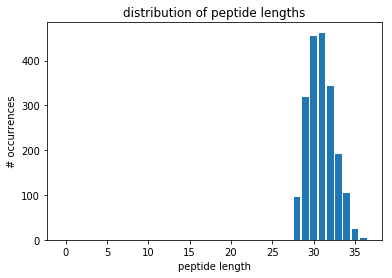

In [4]:
counts = np.bincount(peptide_lengths)

plt.bar(range(len(counts)), counts)
plt.xlabel('peptide length')
plt.ylabel('# occurrences')

plt.title('distribution of peptide lengths')

plt.savefig('tat-barcode-peptide-lengths.png',dpi=300)

In [5]:
observed_lengths = np.argwhere(counts).flatten()
len(observed_lengths)

10

In [6]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
ProtParamData?

## 2.1. Computing hydrophobicity

Requires picking a hydrophobicity scale. Commonly used ones are listed in a table on: https://www.biob.in/2014/05/hydrophobicity-plot-using-biopython.html

In [7]:
kyte_doolittle_scale = { 'A': 1.8,'R':-4.5,'N':-3.5,'D':-3.5,'C': 2.5,
       'Q':-3.5,'E':-3.5,'G':-0.4,'H':-3.2,'I': 4.5,
       'L': 3.8,'K':-3.9,'M': 1.9,'F': 2.8,'P':-1.6,
       'S':-0.8,'T':-0.7,'W':-0.9,'Y':-1.3,'V': 4.2 }

In [8]:
peptide = reference_set[100]
len(peptide)

32

In [9]:
protein_analysis = ProteinAnalysis(peptide)

In [10]:
protein_analysis.protein_scale(kyte_doolittle_scale, window=5)

[-2.8,
 -3.44,
 -4.26,
 -4.0600000000000005,
 -4.18,
 -4.3,
 -4.3,
 -3.4799999999999995,
 -3.6799999999999997,
 -2.42,
 -1.1600000000000001,
 -0.4200000000000001,
 -0.4200000000000001,
 1.24,
 0.18,
 -0.36,
 -0.2800000000000001,
 0.15999999999999995,
 -0.6799999999999999,
 -0.06000000000000001,
 -0.78,
 -0.34,
 -1.34,
 -1.9,
 -2.46,
 -2.2,
 -3.2,
 -3.2]

Okay, to summarize this into fixed-size feature vector, regardless of peptide length, I think we might want to select the most and least hydrophobic regions?

In [11]:
def compute_hydrophobicity_features(protein_analysis, window=5):
    """Return the hydrophobicity of the most and least hydrophobic regions"""
    
    window = min(window, len(protein_analysis.sequence))
    hydrophobicity_windows = protein_analysis.protein_scale(kyte_doolittle_scale, window=window)
    
    return np.array([min(hydrophobicity_windows), np.median(hydrophobicity_windows), max(hydrophobicity_windows)])

In [12]:
compute_hydrophobicity_features(protein_analysis)

array([-4.3 , -2.05,  1.24])

## 2.2. [to-do] Computing sliding window substructure propensities

[To-do!]

## 2.3. Plotting predicted physicochemical properties

In [13]:
n_ref = len(reference_set)
isoelectric_points = np.zeros((n_ref, 1))
secondary_structure_fractions = np.zeros((n_ref, 3))
hydrophobicity_features = np.zeros((n_ref, 3))

for i in range(n_ref):
    analysis_object = ProteinAnalysis(reference_set[i])
    
    # compute properties
    isoelectric_points[i] = analysis_object.isoelectric_point()
    secondary_structure_fractions[i] = analysis_object.secondary_structure_fraction()
    hydrophobicity_features[i] = compute_hydrophobicity_features(analysis_object)

In [14]:
concatenated_features = np.hstack([
    isoelectric_points,
    secondary_structure_fractions,
    hydrophobicity_features,
])

long_feature_names = [
    'isoelectric point (Bjellqvist, 1993-1994)',
    'fraction helical',
    'fraction turn-like',
    'fraction sheet-like',
    'least-hydrophobic window',
    'median of hydrophobic windows',
    'most-hydrophobic window',
]

feature_names = [
    'isoelectric point',
    'fraction helical',
    'fraction turn-like',
    'fraction sheet-like',
    'least-hydrophobic window',
    'median of hydrophobic windows',
    'most-hydrophobic window',
]
n_features = concatenated_features.shape[1]

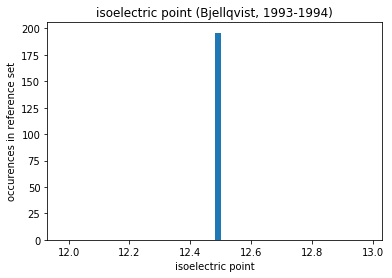

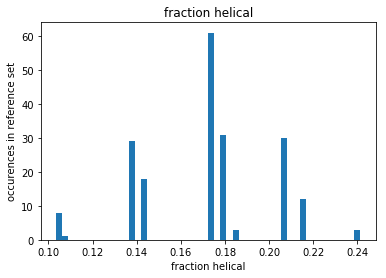

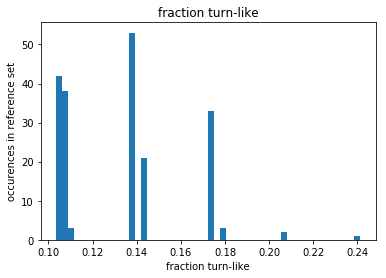

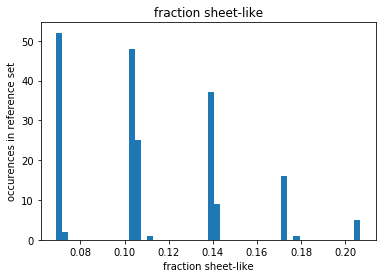

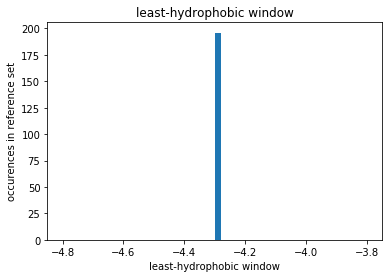

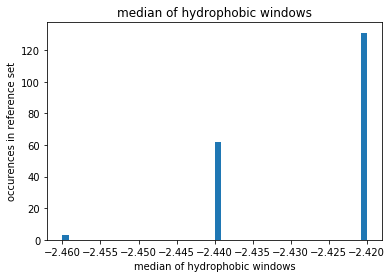

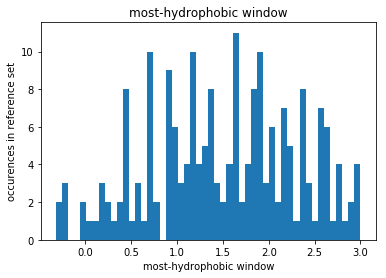

In [24]:
for i in range(n_features):
    plt.figure()
    feature = concatenated_features[:,i]
    
    plt.hist(feature[np.isfinite(feature)], bins=50);
    plt.title(long_feature_names[i])
    plt.xlabel(feature_names[i])
    plt.ylabel('occurences in reference set')

In [15]:
feature_inds = np.arange(len(feature_names))
X_unscaled = concatenated_features[:, feature_inds]
included_features = [feature_names[i] for i in feature_inds]
print(included_features)

['isoelectric point', 'fraction helical', 'fraction turn-like', 'fraction sheet-like', 'least-hydrophobic window', 'median of hydrophobic windows', 'most-hydrophobic window']


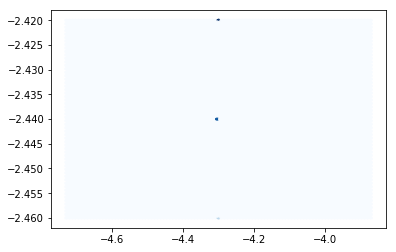

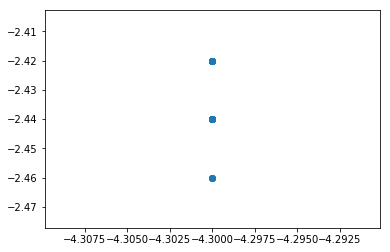

In [26]:
plt.hexbin(hydrophobicity_features[:,0], hydrophobicity_features[:,1], cmap='Blues', bins='log')
plt.figure()
plt.scatter(hydrophobicity_features[:,0], hydrophobicity_features[:,1])

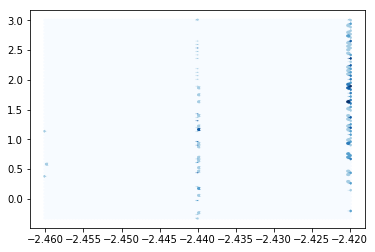

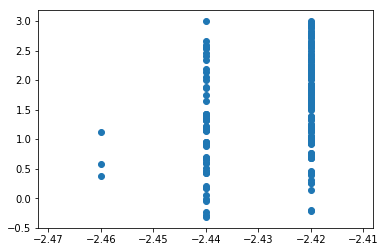

In [27]:
plt.hexbin(hydrophobicity_features[:,1], hydrophobicity_features[:,2], cmap='Blues', bins='log')
plt.figure()
plt.scatter(hydrophobicity_features[:,1], hydrophobicity_features[:,2])

## 2.4. [to-do] Look at sequence properties of reference CPPs (e.g. motifs)

# 3. Defining a physicochemically-based distance metric

Note that these physicochemical properties can have different scales, so if we use raw Euclidean distance on these features, then we'll more strongly penalize violations of whichever feature has the biggest scale...

In [28]:
for i in range(len(included_features)):  print('stdev({}) = {:.3f}'.format(included_features[i], np.std(X_unscaled[:,i])))

stdev(isoelectric point) = 0.000
stdev(fraction helical) = 0.029
stdev(fraction turn-like) = 0.027
stdev(fraction sheet-like) = 0.035
stdev(least-hydrophobic window) = 0.000
stdev(median of hydrophobic windows) = 0.010
stdev(most-hydrophobic window) = 0.797


We'll find a projection of these features that's likely to be "better-behaved," i.e. treat each property as equally important. Later, we might want to weight the features differently, but initially we don't want the feature importances to be determined just by differences in units...

In [29]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
pca.fit(X_unscaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

([<matplotlib.axis.YTick at 0x8c59320>,
 <a list of 4 Text yticklabel objects>)

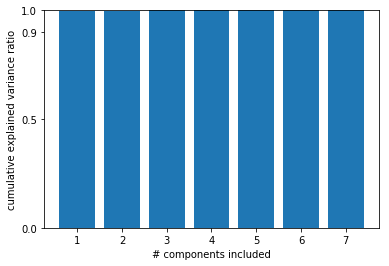

In [30]:
plt.bar(np.arange(X_unscaled.shape[1]) + 1, np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0,1)
plt.xlabel('# components included')
plt.ylabel('cumulative explained variance ratio')
plt.yticks([0,0.5,0.9, 1])

Okay so it looks like we can get away with 2 components just fine. 2 components is better so we can visualize

In [31]:
pca = PCA(n_components=2, whiten=True)
pca.fit(X_unscaled)
X_scaled = pca.transform(X_unscaled)
np.std(X_scaled, 0)

array([0.99744572, 0.99744572])

C:\Users\mcneern\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


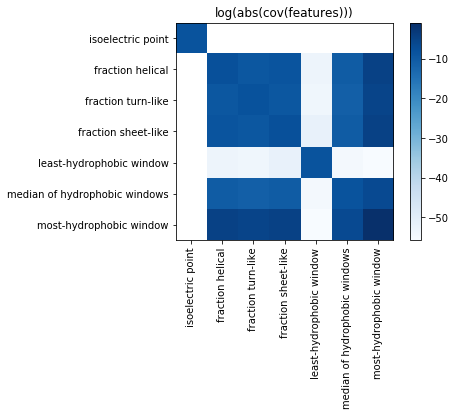

In [32]:
plt.imshow(np.log(np.abs(pca.get_covariance())), cmap='Blues')
plt.colorbar()

plt.title('log(abs(cov(features)))')

plt.xticks(range(len(feature_names)), feature_names, rotation=90);
plt.yticks(range(len(feature_names)), feature_names);

In [33]:
def predict_properties(sequence):
    """return a vector of physicochemical properties"""
    protein_analysis = ProteinAnalysis(sequence)
    
    properties = np.zeros(len(included_features))
    properties[0] = protein_analysis.isoelectric_point()
    properties[1:4] = protein_analysis.secondary_structure_fraction()
    properties[4:7] = compute_hydrophobicity_features(protein_analysis)
    return properties

In [34]:
feature_names

['isoelectric point',
 'fraction helical',
 'fraction turn-like',
 'fraction sheet-like',
 'least-hydrophobic window',
 'median of hydrophobic windows',
 'most-hydrophobic window']

In [35]:
def project(properties):
    """project a vector of properties into space where we expect the Euclidean distance between
    the vectors to be more meaningful than Euclidean distance between the raw property fectors"""
    if len(properties.shape) == 1:
        return pca.transform(properties.reshape((1, len(properties)))).flatten()
    else:
        return pca.transform(properties)

In [36]:
seq = reference_set[0]
predict_properties(seq), project(predict_properties(seq))

(array([12.4800415 ,  0.17241379,  0.13793103,  0.13793103, -4.3       ,
        -2.42      ,  2.16      ]), array([-0.81488739,  0.41553656]))

# 4. Exploratory analysis using this physicochemical distance metric

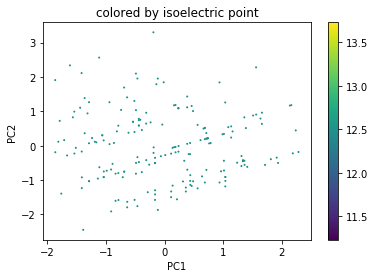

In [37]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1, c=isoelectric_points.flatten())
plt.title('colored by isoelectric point')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

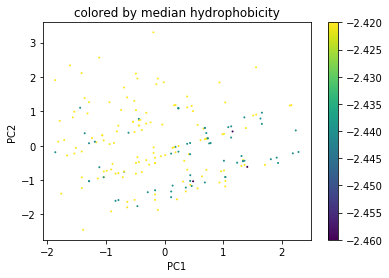

In [38]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1, c=hydrophobicity_features[:,1])
plt.title('colored by median hydrophobicity')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

In [39]:
from scipy.spatial.distance import cdist, pdist, squareform
ref_dist_matrix = squareform(pdist(X_scaled))

In [40]:
from sklearn.cluster import SpectralBiclustering
spec_clust = SpectralBiclustering(n_clusters=20, svd_method='arpack')
spec_clust.fit(ref_dist_matrix)

SpectralBiclustering(init='k-means++', method='bistochastic',
           mini_batch=False, n_best=3, n_clusters=20, n_components=6,
           n_init=10, n_jobs=None, n_svd_vecs=None, random_state=None,
           svd_method='arpack')

In [41]:
inds = np.argsort(spec_clust.column_labels_)

Text(0, 0.5, 'reference peptide')

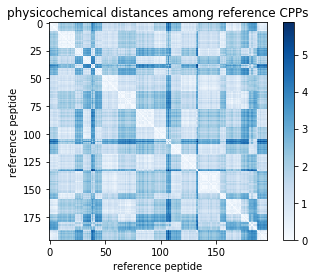

In [42]:
plt.imshow(ref_dist_matrix[inds][:,inds], cmap='Blues')
plt.colorbar()

plt.title('physicochemical distances among reference CPPs')
plt.xlabel('reference peptide')
plt.ylabel('reference peptide')

# 5. Estimate density in the feature projection

Where is CPPSite concentrated?

In [ ]:
X_scaled.shape

In [ ]:
from sklearn.neighbors import KernelDensity
kernel = 'exponential'

In [ ]:
bandwidths = np.logspace(-3,2,num=100)

In [ ]:
from tqdm import tqdm
oos_scores = []

for bandwidth in tqdm(bandwidths):
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde.fit(X_scaled[::2])
    oos_scores.append(kde.score(X_scaled[1::2]))
oos_scores = np.array(oos_scores)

In [ ]:
plt.plot(bandwidths, oos_scores)
plt.xscale('log')
plt.yscale('symlog')

In [ ]:
optimal_bandwidth = bandwidths[np.argmax(oos_scores)]
optimal_bandwidth

To-do: Fancier bandwidth selection.

In [ ]:
kde = KernelDensity(bandwidth=optimal_bandwidth, kernel=kernel)
kde.fit(X_scaled)

In [ ]:
kde.score_samples(X_scaled)

In [ ]:
kde.score_samples([X_scaled[0]])

In [ ]:
# let's visualize the KDE on a grid?

num=200
pad = 0.4
x = np.linspace(X_scaled[:,0].min() - pad, X_scaled[:,0].max() + pad, num)
y = np.linspace(X_scaled[:,1].min() - pad, X_scaled[:,1].max() + pad, num)

X, Y = np.meshgrid(x, y)

In [ ]:
grid = np.array([X.flatten(), Y.flatten()]).T
Z = kde.score_samples(grid).flatten().reshape((num, num))

In [ ]:
plt.contourf(X, Y, np.exp(Z), cmap='Blues')
plt.colorbar()
#plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1)

In [ ]:
plt.contourf(X, Y, Z, cmap='Blues', levels=np.linspace(np.min(Z[np.isfinite(Z)]), np.max(Z), 20))
plt.colorbar()
#plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1)

In [ ]:
np.min(Z)

In [ ]:
plt.contourf(X, Y, np.exp(Z), cmap='Blues')
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1)

# 6. Design peptide libraries by sampling

## 6.1. Define objectives, and a scoring function based on these objectives

In [ ]:
def kde_based_ref_similarity_for_single_peptide(peptide):
    y = project(predict_properties(peptide))
    return kde.score_samples([y])[0]


def similarity_to_reference_set(list_of_sequences):
    """evalute similarity between the properties of list_of_sequences and the reference CPPs"""
    predicted_properties = np.vstack([predict_properties(seq) for seq in list_of_sequences])
    Y_scaled = project(predicted_properties)
    return kde.score_samples(Y_scaled)

def score_library(list_of_sequences):
    return np.mean(similarity_to_reference_set(list_of_sequences))

## 6.2. Examine distribution of scores for random libraries of varying peptide length

In [ ]:
sample_random_peptide = lambda length : ''.join(np.random.choice(standard_amino_acids, size=length))

In [ ]:
from tqdm import tqdm

random_scores = []
lengths = [3,5,10,20]

n_samples = 10000

for length in lengths:
    scores = similarity_to_reference_set([sample_random_peptide(length=length) for _ in range(n_samples)])
    random_scores.append(scores)

In [ ]:
for i in range(len(random_scores)):
    plt.hist(random_scores[i], bins=20, alpha=0.5, label=str(lengths[i]));
plt.legend(title='peptide length')
plt.xlabel('score')
plt.ylabel('probability density')
plt.yticks([])

### 6.2.1. Plot histograms of scores for each of the lengths of peptides from CPPSite

In [ ]:
for length in observed_lengths:
    allowed_peptides = [peptide for peptide in reference_set if len(peptide) == length]
    if len(allowed_peptides) > 50:
        label = str(length)
        plt.hist(similarity_to_reference_set(allowed_peptides), label=label, alpha=0.5, density=True)
plt.legend()

## 6.3. Define a sampling algorithm

### 6.3.1. Define symmetric proposal kernels
Design some proposal kernels $p(\cdot | x)$, where $p(y | x) = p(x | y)$ for all $x,y$, so that the acceptance criterion is convenient / less error-prone.

In [ ]:
def symmetric_one_site_mutate(sequence_string):
    ind_to_mutate = np.random.randint(len(sequence_string))
    residue_to_insert = standard_amino_acids[np.random.randint(len(standard_amino_acids))]
    
    sequence_as_list = list(sequence_string)
    sequence_as_list[ind_to_mutate] = residue_to_insert
    return ''.join(sequence_as_list)

### 6.3.2. Implement random-walk Metropolis-Hastings

In [ ]:
def random_walk_mh(x0, log_prob_func, symmetric_proposal_func, n_steps=1000):
    """Random-walk Metropolis-Hastings
    
    Parameters
    ----------
    x0 : object
        initial state of sampler
    log_prob_func : callable, accepts an object like x0 and returns a float
        unnormalized log probability density function
    symmetric_proposal_func : callable, accepts an object like x0 and returns another object like x0
        assume this samples from a symmetric proposal distribution (p(y|x) = p(x|y))
    n_steps : integer
        number of MCMC steps
    
    Returns
    -------
    traj : [n_steps + 1] list of objects
        trajectory of samples generated by MCMC
    log_probs : [n_steps + 1] array of floats
        unnormalized log-probabilities of the samples
    acceptance_fraction : float in [0,1]
        fraction of accepted proposals
    """
    traj = [x0]
    log_probs = [log_prob_func(x0)]

    acceptances = 0
    r = range(n_steps)
    trange = tqdm(r)
    for n in trange:

        x_proposal = symmetric_proposal_func(traj[-1])
        log_prob_proposal = log_prob_func(x_proposal)

        if np.random.rand() < np.exp(log_prob_proposal - log_probs[-1]):
            traj.append(x_proposal)
            log_probs.append(log_prob_proposal)
            acceptances += 1
        else:
            traj.append(traj[-1])
            log_probs.append(log_probs[-1])

        trange.set_postfix({'log_prob': log_probs[-1], 'accept_fraction': float(acceptances) / (1 + n)})
    del (trange)

    return traj, np.array(log_probs), float(acceptances) / n_steps

### 6.3.3. [to-do] Define asymmetric proposal kernels
To improve efficiency, we may wish to define asymmetric proposal kernels.

### 6.3.4. [to-do] Define length-changing proposal kernels
We may wish to increase or decrease the length of the peptides on the fly.

## 6.4. Run random walk Metropolis-Hastings to sample individual peptides

Interpreting the score as a log probability.

In [ ]:
x0 = sample_random_peptide(length=5)

In [ ]:
peptides, scores, acceptance_rate = random_walk_mh(x0,
               log_prob_func=kde_based_ref_similarity_for_single_peptide,
               symmetric_proposal_func=symmetric_one_site_mutate,
               n_steps=50000,
              )

In [ ]:
plt.hist(random_scores[1], bins=50, alpha=0.5, density=True, label='random');
plt.hist(scores[1000:], bins=50, alpha=0.5, density=True, label='MCMC-sampled');
plt.legend(loc='best')

In [ ]:
plt.plot(scores)
plt.xlabel('iteration')
plt.ylabel('score')
plt.title('KDE-based similarity to reference CPPs')

In [ ]:
peptides[:5], peptides[-5:]

In [ ]:
change_points = peptides[0] == peptides[1]

## 6.5. Analysis: How diverse were the peptides we generated?

In [ ]:
initial_discard = 1000

In [ ]:
peptides_ = peptides[initial_discard:]

In [ ]:
len(set(peptides_)), len(set(peptides_)) / len(peptides_)

In [ ]:
unique_peptides = sorted(list(set(peptides_)))
unique_peptides[:5]

In [ ]:
peptide_index = dict(zip(unique_peptides, list(range(len(unique_peptides)))))

In [ ]:
dtraj = np.array([peptide_index[peptide] for peptide in peptides_], dtype=np.int)

In [ ]:
taus = list(range(100))
acf = [1]
for i in taus[1:]:
    acf.append(np.sum((dtraj[:-i] == dtraj[i:])) / len(dtraj[i:]))

In [ ]:
def hamming_distance(peptide_1, peptide_2):
    return sum([peptide_1[i] != peptide_2[i] for i in range(len(peptide_1))])

In [ ]:
hamming_distance(peptides_[0], peptides_[1000])

## 6.5.1. Bonus: Evaluate correlation times from this trajectory

In [ ]:
plt.plot(taus, acf)
plt.ylim(0,1)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\tau$ (number of MCMC steps)')
plt.ylabel('autocorrelation (identity)')
plt.yticks([0,1])
plt.xlim(0,)

In [ ]:
taus = list(range(1000))
distance_acf = [0]

distance_distributions = [np.zeros(len(peptides_))]

for tau in tqdm(taus[1:]):
    
    distances = np.array([hamming_distance(peptides_[t], peptides_[t+tau]) for t in range(len(peptides_[tau:]))])
    distance_distributions.append(distances)
    
    distance_acf.append(np.mean(distances))

In [ ]:
dmat = np.vstack([d[:len(distance_distributions[-1])] for d in distance_distributions])
dmat.shape

In [ ]:
#alpha = 

plt.plot(taus, distance_acf)

lb = distance_acf - 1.96 * np.std(dmat, 1)
ub = np.minimum(5, distance_acf + 1.96 * np.std(dmat, 1))

plt.fill_between(taus, lb, ub, alpha=0.5)

plt.hlines(len(peptides_[0]), 0, max(taus))

plt.xlabel(r'$\tau$ (number of MCMC steps)')
plt.ylabel('average Hamming distance\n' + r'between iterate $t$ and iterate $t + \tau$ ')

## 6.5.2. Analysis: how similar are these to the closest things in the reference set?

In [ ]:
len5_reference_peptides = [peptide for peptide in reference_set if len(peptide) == 5]

In [ ]:
len(len5_reference_peptides)

In [ ]:
print(sorted(len5_reference_peptides))

In [ ]:
hamming_distances_to_reference = np.zeros((len(unique_peptides), len(len5_reference_peptides)))

for i in range(hamming_distances_to_reference.shape[0]):
    for j in range(hamming_distances_to_reference.shape[1]):
        hamming_distances_to_reference[i,j] = hamming_distance(unique_peptides[i], len5_reference_peptides[j])

In [ ]:
plt.bar(range(6), np.bincount(np.min(hamming_distances_to_reference, 1).astype(np.int)))
plt.xlabel('Hamming distance to most similar reference peptide of same length')
plt.ylabel('# unique peptides sampled')

### 6.5.3. Bonus: construct a PAM matrix from this trajectory

Initially, averaging over all positions.

To-do: Don't average over all positions within the peptide.

In [ ]:
aa_dict = dict(zip(standard_amino_acids, range(len(standard_amino_acids))))

In [ ]:
transition_count_matrix = np.zeros((len(aa_dict), len(aa_dict)))

tau = 200
for t in range(len(peptides_[tau:])):
    for (a, b) in zip(peptides_[t], peptides_[t+tau]):
        transition_count_matrix[aa_dict[a], aa_dict[b]] += 1

In [ ]:
plt.imshow(transition_count_matrix, cmap='Blues', )
plt.xticks(range(len(aa_dict)), standard_amino_acids);
plt.yticks(range(len(aa_dict)), standard_amino_acids);

In [ ]:
# row normalize
P = (transition_count_matrix.T / transition_count_matrix.sum(1)).T
P.sum(1)

In [ ]:
plt.imshow(P, cmap='Blues', )
plt.xticks(range(len(aa_dict)), standard_amino_acids);
plt.yticks(range(len(aa_dict)), standard_amino_acids);

In [ ]:
len5_result = (peptides, scores, acceptance_rate)

## 6.6. Repeat this for 20-mers

In [ ]:
x0 = sample_random_peptide(length=20)
peptides, scores, acceptance_rate = random_walk_mh(x0,
               log_prob_func=kde_based_ref_similarity_for_single_peptide,
               symmetric_proposal_func=symmetric_one_site_mutate,
               n_steps=100000,
              )

In [ ]:

plt.hist(random_scores[-1], bins=20, alpha=0.5, density=True, label='random');
plt.hist(scores[1000:], bins=50, alpha=0.5, density=True, label='MCMC-sampled');
plt.legend(loc='best')

In [ ]:
peptides_ = peptides[initial_discard:]
len(set(peptides_)), len(set(peptides_)) / len(peptides_)

In [ ]:
transition_count_matrix = np.zeros((len(aa_dict), len(aa_dict)))

tau = 200
for t in range(len(peptides_[tau:])):
    for (a, b) in zip(peptides_[t], peptides_[t+tau]):
        transition_count_matrix[aa_dict[a], aa_dict[b]] += 1
# row normalize
P = (transition_count_matrix.T / transition_count_matrix.sum(1)).T

In [ ]:
plt.imshow(P, cmap='Blues', )
plt.xticks(range(len(aa_dict)), standard_amino_acids);
plt.yticks(range(len(aa_dict)), standard_amino_acids);

plt.colorbar()

In [ ]:
len20_reference_peptides = [peptide for peptide in reference_set if len(peptide) == 20]
len(len20_reference_peptides)

In [ ]:
unique_peptides = sorted(list(set(peptides_)))
unique_peptides[:5]

In [ ]:
hamming_distances_to_reference = np.zeros((len(unique_peptides), len(len20_reference_peptides)))

for i in range(hamming_distances_to_reference.shape[0]):
    for j in range(hamming_distances_to_reference.shape[1]):
        hamming_distances_to_reference[i,j] = hamming_distance(unique_peptides[i], len20_reference_peptides[j])

In [10]:
counts = np.bincount(np.min(hamming_distances_to_reference, 1).astype(np.int))

NameError: name 'hamming_distances_to_reference' is not defined

In [ ]:
plt.bar(range(len(counts)), counts)
plt.xlabel('Hamming distance to most similar reference peptide of same length')
plt.ylabel('# unique peptides sampled')

In [ ]:
unique_bags_of_amino_acids = sorted(list(set([''.join(sorted(peptide)) for peptide in peptides_])))

hamming_distances_to_reference = np.zeros((len(unique_bags_of_amino_acids), len(len20_reference_peptides)))

for i in range(hamming_distances_to_reference.shape[0]):
    for j in range(hamming_distances_to_reference.shape[1]):
        hamming_distances_to_reference[i,j] = hamming_distance(unique_bags_of_amino_acids[i], ''.join(sorted(len20_reference_peptides[j])))

In [ ]:
sorted_counts = np.bincount(np.min(hamming_distances_to_reference, 1).astype(np.int))

plt.bar(range(len(counts)), counts, alpha=0.5, label='Hamming distance (order-dependent)')
plt.bar(range(len(sorted_counts)), sorted_counts, alpha=0.5, label='AA composition only')
plt.xlabel('distance to most similar reference peptide of same length')
plt.ylabel('# unique peptides sampled')
plt.legend(loc='best')

In [ ]:
predicted_properties = np.vstack([predict_properties(seq) for seq in tqdm(peptides)])
Y_scaled = project(predicted_properties)

In [ ]:
peptides[0]

In [ ]:
compute_hydrophobicity_features(ProteinAnalysis(peptide))

In [ ]:
for i in range(len(feature_names)):
    plt.figure()
    plt.plot(predicted_properties[:,i])
    plt.ylabel(feature_names[i])
    plt.xlabel('MCMC iteration')

In [ ]:
feature_names

In [ ]:
plt.plot(Y_scaled[:,0], Y_scaled[:,1])

In [ ]:
plt.plot(Y_scaled[:,0])

In [ ]:
plt.plot(Y_scaled[:,1])

In [ ]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1, label='reference')
plt.scatter(Y_scaled[:,0], Y_scaled[:,1], s=0.1, label='generated')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# 7. Next steps

## 7.1. Stratified sampling
JDC suggests to sample bands of increasing distance from the reference CPPs.

In [ ]:
def in_distance_band(x, r_min, r_max):
    """return True if x is between r_min and r_max of at least one reference CPP"""
    pass
    
def stratified_objective(sequence, r_min, r_max):
    """return -inf if outside of (r_min, r_max) band, else return usual objective(sequence)"""
    pass

# 8. Bonus: making it faster

If speed becomes an important limitation, we might improve efficiency by:

* Vectorizing interpreter-bound loops
* Optimizing proposal distribution (e.g. making it non-uniform or asymmetric)

## 8.1 Timing

In [11]:
%%time
seq = reference_set[0]

protein_analysis = ProteinAnalysis(seq)
protein_analysis.isoelectric_point()

Wall time: 0 ns


In [12]:
%%time
score_library(trial_library)

NameError: name 'score_library' is not defined